In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
db_path = 'mimic3.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

In [3]:
query = "SELECT * FROM CAREGIVERS;"

caregivers_df = pd.read_sql_query(query, connection)

In [4]:
caregivers_df.head()

,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory


In [41]:
len(caregivers_df['LABEL'].unique())

232

Visualizing the distribution of the top ten most occurring roles in the caregiver data.

In [6]:
# Get top ten labels and visualize using a pichart
top_ten_caregiver_roles = caregivers_df['LABEL'].value_counts(ascending=False)[:10]
top_ten_caregiver_roles

LABEL
RO       1658
MD       1380
Res      1238
RN       1185
MDs       226
Rehab     167
RRT       131
MS        111
PCT       111
RPH        78
Name: count, dtype: int64

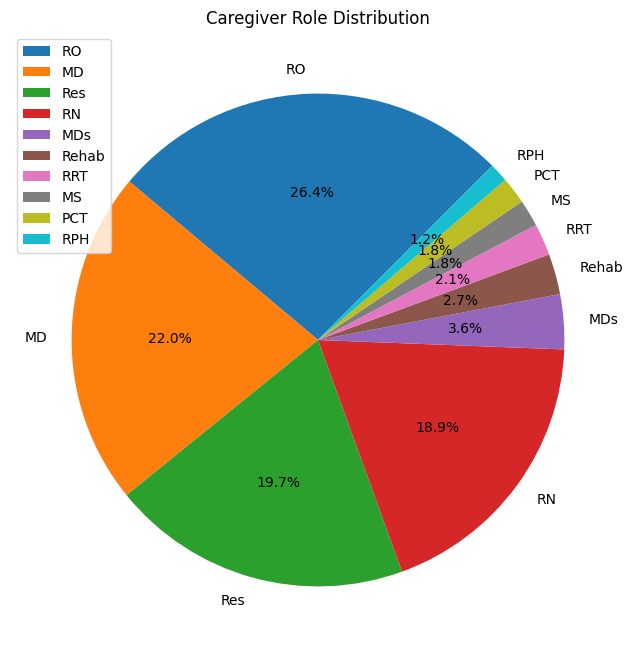

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(top_ten_caregiver_roles, labels=top_ten_caregiver_roles.index, autopct='%1.1f%%', startangle=45, rotatelabels=False)
plt.title("Caregiver Role Distribution")
plt.legend()
plt.show()

Let's create a word cloud analysis for discharge events.

In [8]:
from wordcloud import WordCloud

query = 'SELECT category, text FROM NOTEEVENTS LIMIT 100000;'
noteevents_df = pd.read_sql_query(query, connection)

In [9]:
noteevents_df.head()

,CATEGORY,TEXT
0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,Discharge summary,Admission Date: [**2119-5-4**] D...
3,Discharge summary,Admission Date: [**2124-7-21**] ...
4,Discharge summary,Admission Date: [**2162-3-3**] D...


In [10]:
# Filter only discharge events
noteevents_df.dropna(inplace=True)
discharge_events_df = noteevents_df[noteevents_df['CATEGORY'] == 'Discharge summary']
discharge_events_df.shape

(59652, 2)

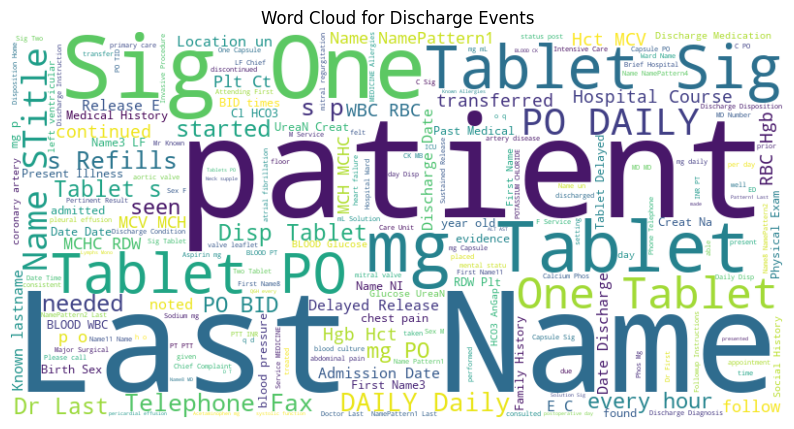

In [11]:
# Create word cloud
discharge_text = " ".join(discharge_events_df['TEXT'])
discharge_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(discharge_text)

plt.figure(figsize=(10, 6))
plt.imshow(discharge_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Discharge Events")
plt.show()

Visualize Patient Transfers and Care Units
- Number of transfers for each care unit
- Average length of stay for each care unit

In [12]:
transfers_query = 'SELECT * FROM TRANSFERS WHERE EVENTTYPE = "transfer";'
transfers_df = pd.read_sql_query(transfers_query, connection)

In [13]:
transfers_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,657,111,192123,254245,carevue,transfer,CCU,MICU,7,23,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
1,658,111,192123,None,carevue,transfer,MICU,None,23,45,2142-05-04 20:38:33,2142-05-05 11:46:32,15.13
2,661,111,155897,None,metavision,transfer,MICU,None,52,32,2144-07-01 05:19:39,2144-07-01 06:28:29,1.15
3,662,111,155897,249202,metavision,transfer,None,MICU,32,52,2144-07-01 06:28:29,2144-07-01 08:07:16,1.65
4,663,111,155897,None,metavision,transfer,MICU,None,52,32,2144-07-01 08:07:16,2144-07-01 08:13:51,.11


In [14]:
transfers_df.shape

(144045, 13)

In [15]:
# Filter out rows where curr_careunit is NONE
transfers_df.dropna(subset=['CURR_CAREUNIT'], inplace=True)

In [16]:
transfers_df.shape

(60413, 13)

In [17]:
transfers_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,657,111,192123,254245,carevue,transfer,CCU,MICU,7,23,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
3,662,111,155897,249202,metavision,transfer,None,MICU,32,52,2144-07-01 06:28:29,2144-07-01 08:07:16,1.65
5,664,111,155897,249202,metavision,transfer,None,MICU,32,23,2144-07-01 08:13:51,2144-07-01 17:56:31,9.71
10,673,112,173177,251972,carevue,transfer,None,MICU,17,50,2196-09-28 00:30:29,2196-09-29 03:50:53,27.34
12,679,114,178393,258626,carevue,transfer,None,CSRU,27,23,2146-08-29 17:59:00,2146-08-31 13:30:00,43.52


In [18]:
num_transfers_per_care_unit_df = transfers_df['CURR_CAREUNIT'].value_counts().reset_index()
num_transfers_per_care_unit_df.columns = ['care_unit', 'num_transfers']
num_transfers_per_care_unit_df

,care_unit,num_transfers
0,NICU,13601
1,MICU,13079
2,CSRU,12178
3,SICU,7134
4,NWARD,5227
5,CCU,5090
6,TSICU,4104


In [19]:
transfers_df['LOS'] = pd.to_numeric(transfers_df['LOS'], errors='coerce')
avg_los_per_care_unit = transfers_df.groupby('CURR_CAREUNIT')['LOS'].mean().reset_index()
avg_los_per_care_unit.columns = ['care_unit', 'avg_los']
avg_los_per_care_unit

,care_unit,avg_los
0,CCU,68.462128
1,CSRU,63.839635
2,MICU,81.737970
3,NICU,139.887835
4,NWARD,53.020140
5,SICU,102.895983
6,TSICU,77.232829


In [20]:
avg_los_and_num_transfers_per_careunit_df = pd.merge(num_transfers_per_care_unit_df, avg_los_per_care_unit, on='care_unit', how='inner')
avg_los_and_num_transfers_per_careunit_df

,care_unit,num_transfers,avg_los
0,NICU,13601,139.887835
1,MICU,13079,81.737970
2,CSRU,12178,63.839635
3,SICU,7134,102.895983
4,NWARD,5227,53.020140
5,CCU,5090,68.462128
6,TSICU,4104,77.232829


C:\Users\william\AppData\Local\Temp\ipykernel_18868\3150851951.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


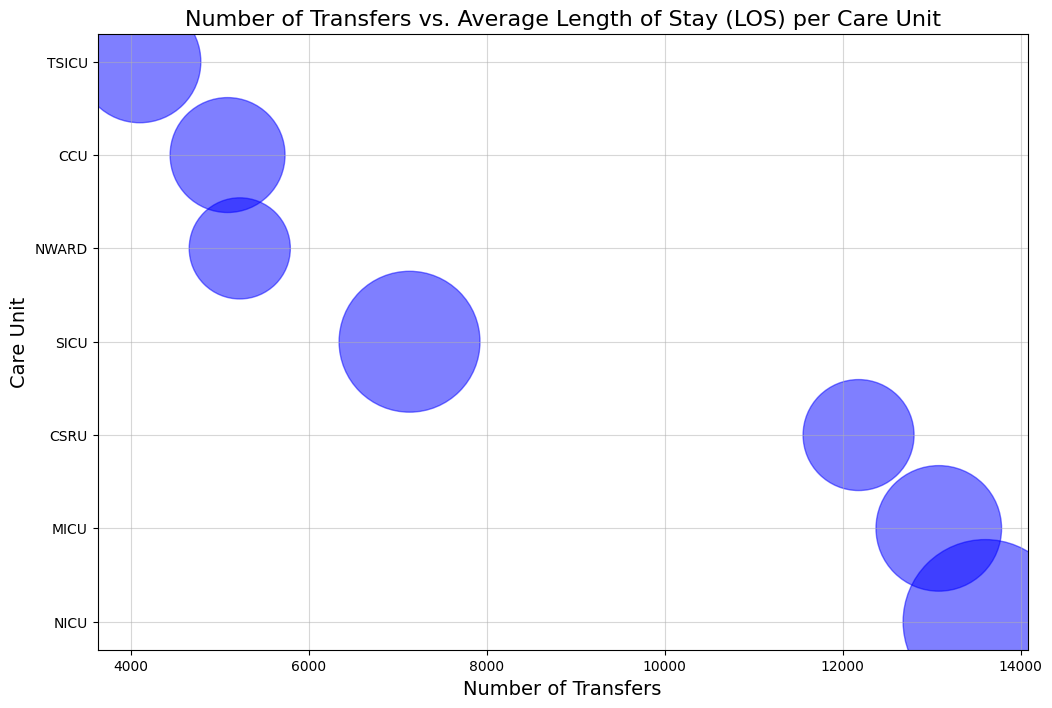

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(
    avg_los_and_num_transfers_per_careunit_df['num_transfers'], 
    avg_los_and_num_transfers_per_careunit_df['care_unit'], 
    s=avg_los_and_num_transfers_per_careunit_df['avg_los'] * 100,
    alpha=0.5, 
    color='blue',
    cmap='viridis'
)

plt.title("Number of Transfers vs. Average Length of Stay (LOS) per Care Unit", fontsize=16)
plt.xlabel("Number of Transfers", fontsize=14)
plt.ylabel("Care Unit", fontsize=14)
plt.grid(alpha=0.5)
plt.show()

Let's visualize the relationship between the number of diagonses and procedures per ethnicity.

In [22]:
ethnicity_query = 'SELECT subject_id, ethnicity FROM ADMISSIONS;'
ethnicity_df = pd.read_sql_query(ethnicity_query, connection)

In [23]:
diagnosis_query = 'SELECT * FROM DIAGNOSES_ICD'
diagnoses_df = pd.read_sql_query(diagnosis_query, connection)

In [24]:
procedures_query = 'SELECT * FROM PROCEDURES_ICD'
procedures_df = pd.read_sql_query(procedures_query, connection)

In [25]:
ethnicity_df.head()

,SUBJECT_ID,ETHNICITY
0,22,WHITE
1,23,WHITE
2,23,WHITE
3,24,WHITE
4,25,WHITE


In [26]:
ethnicity_df['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [27]:
diagnoses_df.head()
diagnoses_df.shape

(651047, 5)

In [28]:
procedures_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331


In [29]:
# get total number of diagnoses for each subject
num_diagnoses_per_patient = diagnoses_df.groupby('SUBJECT_ID').size().reset_index(name='num_diagnoses')
num_diagnoses_per_patient

,SUBJECT_ID,num_diagnoses
0,2,3
1,3,9
2,4,9
3,5,3
4,6,8
...,...,...
46515,99985,13
46516,99991,17
46517,99992,12
46518,99995,17


In [30]:
num_procedures_per_patient = procedures_df.groupby('SUBJECT_ID').size().reset_index(name='num_procedures')
num_procedures_per_patient

,SUBJECT_ID,num_procedures
0,2,1
1,3,6
2,4,3
3,5,1
4,6,5
...,...,...
42209,99985,5
42210,99991,7
42211,99992,2
42212,99995,3


In [31]:
# Merge all three tables
diagnoses_procedures_ethnicity_df = ethnicity_df.merge(num_diagnoses_per_patient, on='SUBJECT_ID', how='left')
diagnoses_procedures_ethnicity_df = diagnoses_procedures_ethnicity_df.merge(num_procedures_per_patient, on='SUBJECT_ID', how='right')
diagnoses_procedures_ethnicity_df

,SUBJECT_ID,ETHNICITY,num_diagnoses,num_procedures
0,2,ASIAN,3,1
1,3,WHITE,9,6
2,4,WHITE,9,3
3,5,ASIAN,3,1
4,6,WHITE,8,5
...,...,...,...,...
54450,99985,WHITE,13,5
54451,99991,WHITE,17,7
54452,99992,WHITE,12,2
54453,99995,WHITE,17,3


In [32]:
# Sum num_diagnoses and num_procedures for each ethnicity
summed_ethnicity_df = diagnoses_procedures_ethnicity_df.groupby('ETHNICITY')[['num_diagnoses', 'num_procedures']].sum().reset_index()
summed_ethnicity_df

,ETHNICITY,num_diagnoses,num_procedures
0,AMERICAN INDIAN/ALASKA NATIVE,706,257
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,90,13
2,ASIAN,17252,6589
3,ASIAN - ASIAN INDIAN,6383,1267
4,ASIAN - CAMBODIAN,735,216
5,ASIAN - CHINESE,4458,1651
6,ASIAN - FILIPINO,1328,122
7,ASIAN - JAPANESE,47,16
8,ASIAN - KOREAN,143,48
9,ASIAN - OTHER,265,99


In [33]:
summed_ethnicity_df = summed_ethnicity_df.sort_values(by='num_diagnoses', ascending=False)[:10].reset_index()
summed_ethnicity_df

,index,ETHNICITY,num_diagnoses,num_procedures
0,36,WHITE,878079,294576
1,13,BLACK/AFRICAN AMERICAN,252172,55399
2,35,UNKNOWN/NOT SPECIFIED,48071,26931
3,17,HISPANIC OR LATINO,33180,10760
4,30,OTHER,28020,10138
5,2,ASIAN,17252,6589
6,25,HISPANIC/LATINO - PUERTO RICAN,12196,2603
7,34,UNABLE TO OBTAIN,11054,4563
8,31,PATIENT DECLINED TO ANSWER,7607,3673
9,3,ASIAN - ASIAN INDIAN,6383,1267


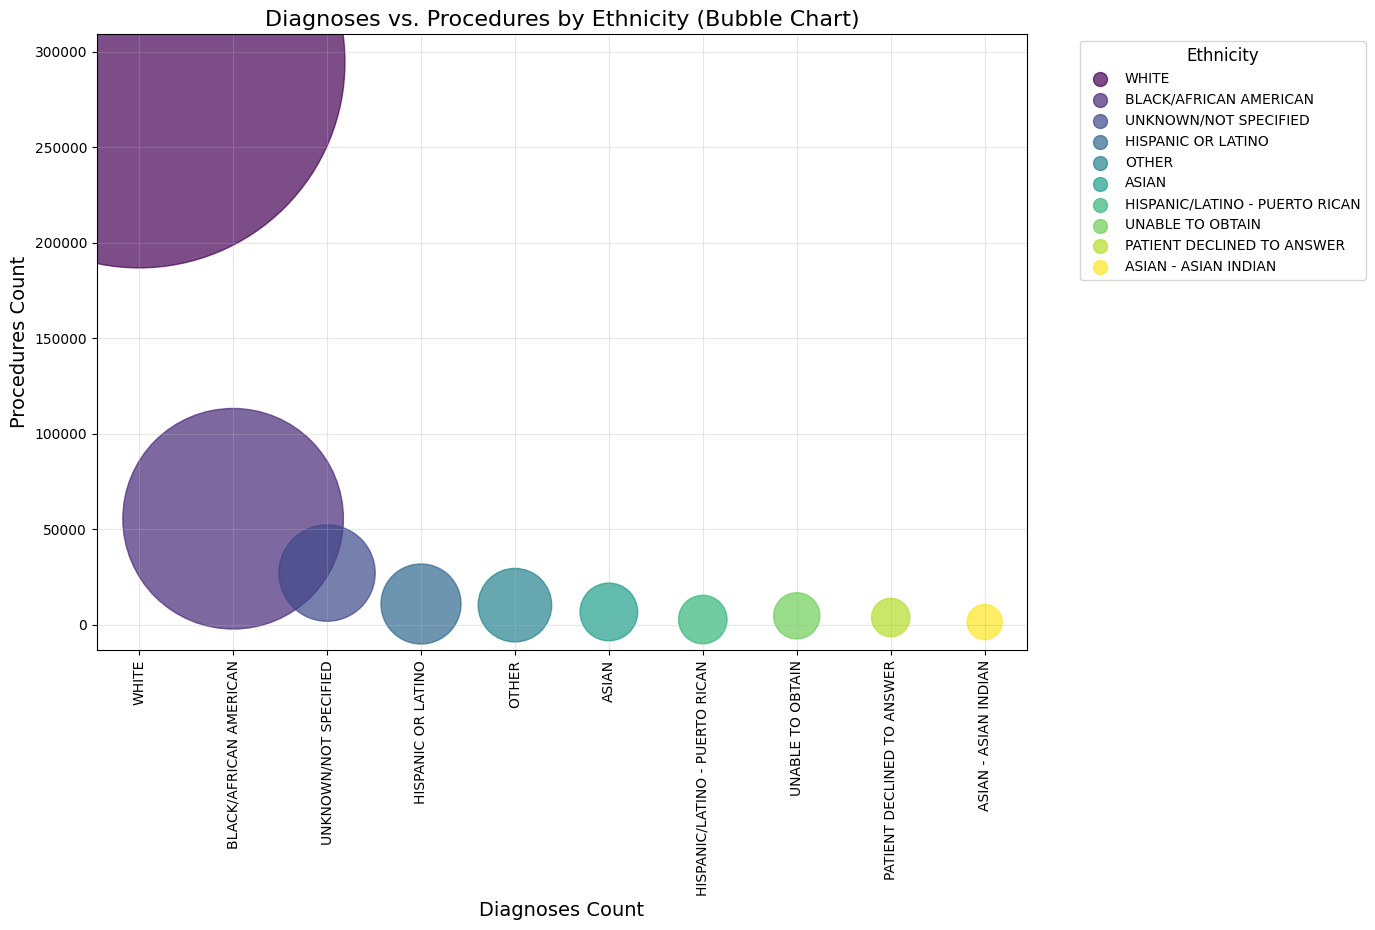

In [44]:
import numpy as np

ethnicities = summed_ethnicity_df['ETHNICITY'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(ethnicities)))
color_map = dict(zip(ethnicities, colors))

summed_ethnicity_df['color'] = summed_ethnicity_df['ETHNICITY'].map(color_map)

plt.figure(figsize=(12, 8))
plt.scatter(
    summed_ethnicity_df['ETHNICITY'], 
    summed_ethnicity_df['num_procedures'], 
    s=summed_ethnicity_df['num_diagnoses'] * 0.1,
    alpha=0.7, 
    c=np.arange(len(summed_ethnicity_df)),
    cmap='viridis'
)

for ethnicity, color in color_map.items():
    plt.scatter([], [], color=color, label=ethnicity, s=100, alpha=0.7)

plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.xlabel("Diagnoses Count", fontsize=14)
plt.xticks(rotation=90)
plt.ylabel("Procedures Count", fontsize=14)
plt.title("Diagnoses vs. Procedures by Ethnicity (Bubble Chart)", fontsize=16)
plt.grid(alpha=0.3)
plt.show()

Let's create a sunburst chart to visualize the distribution of procedures grouped by ethnicity and insurance type.

In [35]:
# Get insurance data
ethnicity_insurance_query = 'SELECT subject_id, ethnicity, insurance FROM ADMISSIONS;'
ethnicity_insurance_df = pd.read_sql_query(ethnicity_insurance_query, connection)

In [36]:
ethnicity_insurance_df.head()

,SUBJECT_ID,ETHNICITY,INSURANCE
0,22,WHITE,Private
1,23,WHITE,Medicare
2,23,WHITE,Medicare
3,24,WHITE,Private
4,25,WHITE,Private


In [37]:
combined_df = pd.merge(ethnicity_insurance_df, procedures_df, on='SUBJECT_ID')
combined_df

,SUBJECT_ID,ETHNICITY,INSURANCE,ROW_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,22,WHITE,Private,9894,165315,1,9604
1,22,WHITE,Private,9895,165315,2,9671
2,22,WHITE,Private,9896,165315,3,9634
3,23,WHITE,Medicare,105252,152223,1,3613
4,23,WHITE,Medicare,105253,152223,2,3615
...,...,...,...,...,...,...,...
426934,98813,WHITE,Private,153043,170407,2,9604
426935,98813,WHITE,Private,153044,170407,3,9671
426936,98813,WHITE,Private,153045,170407,4,3893
426937,98813,WHITE,Private,228656,194565,1,8659


In [38]:
aggregated_combined_df = combined_df.groupby(['ETHNICITY', 'INSURANCE']).size().reset_index(name='num_procedures')
aggregated_combined_df.head()

,ETHNICITY,INSURANCE,num_procedures
0,AMERICAN INDIAN/ALASKA NATIVE,Government,1
1,AMERICAN INDIAN/ALASKA NATIVE,Medicaid,71
2,AMERICAN INDIAN/ALASKA NATIVE,Medicare,62
3,AMERICAN INDIAN/ALASKA NATIVE,Private,119
4,AMERICAN INDIAN/ALASKA NATIVE,Self Pay,4


In [ ]:
import plotly.express as px
fig = px.sunburst(
    aggregated_combined_df,
    path=['ETHNICITY', 'INSURANCE'], 
    values='num_procedures',          
    title="Sunburst Chart: Ethnicity, Insurance, and Procedures",
    color='num_procedures',           
    color_continuous_scale='viridis',
    width=1000,                       
    height=800 
)

fig.show()